
# <font color='green'>sentiment Analysis</font> ![title](./resources/img/sent_twitter.png)

## <font color='red'>Learning Data</font>
***

#### Import liberies

Refer to the web pages for individual libraries
* [Pandas](http://pandas.pydata.org/), to load and manage data
* [Matplotlib](http://matplotlib.org/), for visualization
* [numpy](http://www.numpy.org/) for painting representation and manipulation
* [re](https://docs.python.org/3/library/re.html) for regular expression
* [nltk](http://www.nltk.org/) for pretreatment

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import nltk

%matplotlib inline

#### Reading the dataset
Some of the data "downloaded_cleansed_B" is produced out of the "downloaded_cleansed_A". The difference is:
- "downloaded_cleansed_A" has three columns that we won't use.
- "downloaded_cleansed_A" has repeatted tweets.

In [2]:
df = pd.read_csv('./data/train/downloaded_cleansed_B.tsv', sep= '\t', header=None)
print (df.shape)
df.head()

(9665, 4)


,0,1,2,3
0,264183816548130816,15140428,positive,Gas by my house hit $3.39!!!! I'm going to Cha...
1,263405084770172928,591166521,negative,Not Available
2,262163168678248449,35266263,negative,Not Available
3,264249301910310912,18516728,negative,Iranian general says Israel's Iron Dome can't ...
4,262682041215234048,254373818,neutral,Not Available


Note that some tweets are "Not Available". We will reject them because it will not help in the analysis of feelings

#### Supprimer tous les tweets "NOT AVAILABLE"

In [3]:
df = df[df[3] != "Not Available"]
df.head()

,0,1,2,3
0,264183816548130816,15140428,positive,Gas by my house hit $3.39!!!! I'm going to Cha...
3,264249301910310912,18516728,negative,Iranian general says Israel's Iron Dome can't ...
6,264105751826538497,147088367,positive,with J Davlar 11th. Main rivals are team Polan...
7,264094586689953794,332474633,negative,"Talking about ACT's &amp;&amp; SAT's, deciding..."
9,254941790757601280,557103111,negative,"They may have a SuperBowl in Dallas, but Dalla..."


In [4]:
df.shape

(7205, 4)

#### <font color='blue'>Training tweets are too limited: just 7205 tweets ...</font>

#### Draw the data

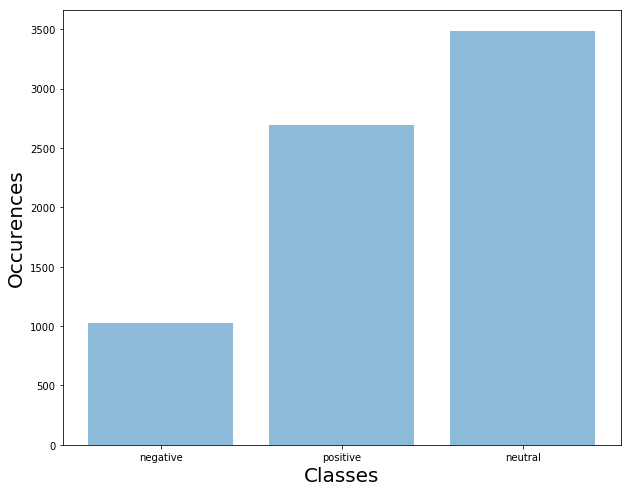

In [5]:
# calculate the total number of occurrences of each class
y = [len(df[df[2] == i]) for i in ['negative', 'positive', 'neutral']]
# X axis
objects = ['negative', 'positive', 'neutral']
x_pos = range(len(objects))

# Draw Diagram
plt.figure(figsize=(10,8))
plt.bar(x_pos, y, alpha=0.5)
plt.xticks(x_pos, objects)
plt.ylabel('Occurences').set_size(20)
plt.xlabel('Classes').set_size(20)

#### Interpretation
From the graph above, we can clearly note that the "negative" class has the fewest samples in the data compared to "positive" and "neutral". As a result, the data appears to be unbalanced and underfit the "negative" class.

In [6]:
raw_tweets = list(df[3])
print (raw_tweets[0])
#notice the emoticon on the end of the sentence.

Gas by my house hit $3.39!!!! I'm going to Chapel Hill on Sat. :)


In [7]:
raw_tweets[14] #test the negation

"One ticket left for the @49ers game tomorrow!  Don't miss the rematch of the NFC Championship game against the NY Giants!  Hit me up!"

***
## <font color='red'>Pre-train the tweets</font>
https://nlp.stanford.edu/IR-book/html/htmledition/determining-the-vocabulary-of-terms-1.html
***

#### Delete slangs from tweets
By slangs, we mean words like:
- i've --> I have
- 12be --> want to be
- *4u  --> kiss for you
- ...

And these parallel-terms are read from <font color='red'>'./resources/internetSlangs.txt'</font> file. Here is the first five lines in that file:
- *4u,%,kiss for you
- *67,%,unknown
- *eg*,%,evil grin
- 7734,%,hello
- 0day,%,software illegally obtained before it was released

In [8]:
def loadSlangs(filename):
    """
    This function reads the file that contains the slangs, and put them in a dictionary such that
    the key is the "slang" and the value is the acronym.
    slangs['i've'] = 'i have'
    slang['12be'] = 'want to be'
    ...
    CAUTION: the keys and values are lower-case letters
    """
    slangs={}
    fi=open(filename,'r')
    line=fi.readline()
    while line:
        l=line.split(r',%,')
        if len(l) == 2:
            slangs[l[0].lower()]=l[1][:-1].lower()  #HERE
        line=fi.readline()
    fi.close()
    return slangs


def replaceSlangs(tweet,slangs):
    """
    This function is used to replace the slang in the original tweets and replace them with the acronym.
    And it's also returns the the tweet in lower-case letters
    """
    result=''
    tweet = tweet.lower()
    words=tweet.split()
    for w in words:
        if w in slangs.keys():
            result=result+slangs[w]+" "
        else:
            result=result+w+" "
    return result.strip()

slangs = loadSlangs('./resources/internetSlangs.txt')
##HERE##
raw_tweets = [replaceSlangs(tweet, slangs) for tweet in raw_tweets]

In [9]:
# Gas by my house hit $3.39!!!! I'm going to Chapel Hill on Sat. :)
print (raw_tweets[0])

gas by my house hit $3.39!!!! i'm going to chapel hill on sat. :)


In [10]:
def load_apostrophe_words(filename):
    """
    This function reads the file that contains all words that have apostrophe, and put them in a dictionary 
    such that the key is the "word containing apostrophe" and the value is the "the word without apostrophe".
    slangs['i've'] = 'i have'
    slang['I'm] = 'I am'
    ...
    CAUTION: the keys and values are lower-case letters
    """
    apo={}
    fi=open(filename,'r')
    line=fi.readline()
    while line:
        l=line.split(r',%,')
        if len(l) == 2:
            apo[l[0].lower()]=l[1][:-1].lower()
        line=fi.readline()
    fi.close()
    return apo


def replace_apostrophe(tweet,apos):
    result=''
    words=tweet.split()
    for w in words:
        if w in apos.keys():
            result=result+apos[w]+" "
        else:
            result=result+w+" "
    return result.strip()

apos = load_apostrophe_words('./resources/apostrophe_words.txt')
raw_tweets = [replace_apostrophe(tweet, apos) for tweet in raw_tweets]

In [11]:
# One ticket left for the @49ers game tomorrow!  Don't miss the rematch of the NFC Championship game against the NY Giants!  Hit me up!
raw_tweets[14]

'one ticket left for the @49ers game tomorrow! do not miss the rematch of the no fucking clue championship game against the ny giants! hit me up!'

#### create a file manually with the parasite words "firasFeatures.txt"
* Delete the 7,000 least frequent words
* number of features decreased from 74,414 to 66,156
* just leave the words with a second occurance to 2
* test run from 64.69% to 64.85%

parasite words are the words used as a filler, like ("you know", "kindda", "sort of", ...etc.)

In [12]:
# This is, basically, deletes the parasite words
parasite_words = loadSlangs('./resources/firasFeatures.txt') 
raw_tweets = [replaceSlangs(tweet, parasite_words) for tweet in raw_tweets]

In [13]:
print (len(raw_tweets))
print (raw_tweets[0])
raw_tweets[6:10]

7205
gas by my house hit $3.39!!!! i am going to chapel hill on sat. :)


['apple software, retail   out in overhaul: san francisco apple inc ceo tim cook on monday replaced the heads... http://t.co/x49zeosg',
 "@oluoch @victor_otti @kunjand i just watched it! sridevi's comeback.... you remember her from the 90s?? sun mornings on nta ;)",
 '#livewire nadal confirmed for mexican open in february: rafael nadal is set to play at the me... http://t.co/zguxpcnc #livewireathletics',
 '@msshelahy i didnt want to just pop up... but yep we have chapel hill next wednesday you should come.. and shes great ill tell her you asked']

Apply standard preprocessing techniques

* https://nlp.stanford.edu/IR-book/html/htmledition/tokenization-1.html
* https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html


#### Use NRC emoticon lexicon

* We will replace the emoticon with its associated meaning.

In [14]:
from nltk.tokenize import TweetTokenizer

TT = TweetTokenizer()

def emoticondictionary(filename):
    """
    Reads the emoticon file and represents it as dictionary where the emoticon is the key, 
    and its indication as a value
    """
    emo_scores = {'Positive': 'positive', 'Extremely-Positive': 'positive', 
                  'Negative': 'negative','Extremely-Negative': 'negative',
                  'Neutral': 'neutral'}
    emo_score_list = {}
    fi = open(filename,"r")
    l = fi.readline()
    while l:
        #replace the "Non-break space" with the ordinary space " "
        l = l.replace("\xa0"," ") #HERE
        li = l.split(" ")
        l2 = li[:-1] #removes the polarity of the emoticon ('negative', 'positive')
        l2.append(li[len(li) - 1].split("\t")[0]) #gets the last emoticon attached to the polarity by '\t'
        sentiment=li[len(li) - 1].split("\t")[1][:-1] #gets only the polarity, and removes '\n'
        score=emo_scores[sentiment]
        l2.append(score)
        for i in range(0,len(l2)-1):
            emo_score_list[l2[i]]=l2[len(l2)-1]
        l=fi.readline()
    return emo_score_list

dict = emoticondictionary('./resources/emoticon.txt')
# print (dict)
# print (list(dict.keys()))
# print (list(dict.values()))


# substititue emoticon with its associated sentiment
def subsEmoticon(tweet,d):
    l = TT.tokenize(tweet)
    tweet = [d[i] if i in d.keys() else i for i in l]
    return tweet

raw_tweets = [subsEmoticon(tweet, dict) for tweet in raw_tweets]

print(":D X3 :|")
subsEmoticon(":D X3 :|", dict)

:D X3 :|


['positive', 'positive', 'neutral']

In [15]:
# gas by my house hit $3.39!!!! i am going to chapel hill on sat. :)
print (len(raw_tweets))
raw_tweets[0]

7205


['gas',
 'by',
 'my',
 'house',
 'hit',
 '$',
 '3.39',
 '!',
 '!',
 '!',
 'i',
 'am',
 'going',
 'to',
 'chapel',
 'hill',
 'on',
 'sat',
 '.',
 'positive']

Note that the 'positive' entry is due to the :) emoticon.

#### Handle Negation

Following the work of Pang et al.(2002), we define a negated context as a segment of a tweet that starts with a negation word (e.g., no, never) and ends with one of the punctuation marks: ‘,’, ‘.’, ‘:’, ‘;’, ‘!’, ‘?’.

In [16]:
negation_words = set(['barely', 'hardly', 'lack', 'never', 'neither', 'no', 'nobody', \
                      'not', 'nothing', 'none', 'nowhere', 'shortage', 'scarcely'])
punctuations = [',', '.', ':', ';', '!', '?']

def handle_negation(tweet):
    output = []
    negate = False
    for word in tweet:
        if word in punctuations and negate:
            negate = False
        if negate:
            output.append(word+"_not")
        else:
            output.append(word)
        if word in negation_words:
            negate = True
    return output

raw_tweets = [handle_negation(tweet) for tweet in raw_tweets]

In [17]:
#one ticket left for the @49ers game tomorrow! do not miss the rematch of the no fucking clue championship game against the ny giants! hit me up!
raw_tweets[14]

['one',
 'ticket',
 'left',
 'for',
 'the',
 '@49ers',
 'game',
 'tomorrow',
 '!',
 'do',
 'not',
 'miss_not',
 'the_not',
 'rematch_not',
 'of_not',
 'the_not',
 'no_not',
 'fucking_not',
 'clue_not',
 'championship_not',
 'game_not',
 'against_not',
 'the_not',
 'ny_not',
 'giants_not',
 '!',
 'hit',
 'me',
 'up',
 '!']

In [18]:
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer

mmer = WordNetLemmatizer()

# Lemmatize the tweets
def _lemma(tweet):
    return ' '.join([mmer.lemmatize(word) for word in tweet])

stemmed_tweets = [_lemma(tweet) for tweet in raw_tweets]


def preprocess(tweet):
    # delete symbols and URIs and tags (keep # and _)
    tweet =  ' '.join(re.sub("(@[A-Za-z0-9_]+)|([^0-9A-Za-z_# \t])|(\w+:\/\/\S+)", '', tweet).split()) #here _#
    # Convert '@username' to 'at_user'
    # tweet = re.sub('@[^\s]+','at_user',tweet)
    # remove hashtags
    # tweet = re.sub(r'#\s', '', tweet)
    # remove numbers
    tweet = re.sub('[0-9]', '', tweet)
    # remove additional spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    # replace the occurrence of 2 or more characters in a word, eg. loooong -> loong
    tweet = re.sub(r'(.)\1{2,}', r'\1\1', tweet)
    return tweet

preprocessed_tweets = [preprocess(tweet) for tweet in stemmed_tweets]

In [19]:
# "@oluoch @victor_otti @kunjand i just watched it! sridevi's comeback.... you remember her from the 90s?? sun mornings on nta positive"
print (len(preprocessed_tweets))
print (preprocessed_tweets[7])

7205
i just watched it sridevis comeback you remember her from the sun morning on nta positive


In [20]:
print (preprocessed_tweets[14])

one ticket left for the game tomorrow do not miss_not the_not rematch_not of_not the_not no_not fucking_not clue_not championship_not game_not against_not the_not ny_not giants_not hit me up


#### Delete stopwords
https://nlp.stanford.edu/IR-book/html/htmledition/dropping-common-terms-stop-words-1.html

In [21]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend([word+'_not' for word in stop_words])
stop_words = set(stop_words)
stop_words.update('j', 'im')
print (len(stop_words))

# remove stopwords
def rem_stop(tweet):
    words = tweet.split()
    tweet = ' '.join([word for word in words if word not in stop_words])
    return tweet

final_tweets = [rem_stop(tweet) for tweet in preprocessed_tweets]

#len(final_tweets)

print("\nCompare tweets before / after")
df['final_tweets'] = final_tweets
df[[3, 'final_tweets']].head(10)

359

Compare tweets before / after


,3,final_tweets
0,Gas by my house hit $3.39!!!! I'm going to Cha...,gas house hit going chapel hill sat positive
3,Iranian general says Israel's Iron Dome can't ...,iranian general say israels iron dome deal_not...
6,with J Davlar 11th. Main rivals are team Polan...,davlar th main rival team poland hopefully mak...
7,"Talking about ACT's &amp;&amp; SAT's, deciding...",talking acts sats deciding want go college app...
9,"They may have a SuperBowl in Dallas, but Dalla...",may superbowl dallas dallas winning_not superb...
10,Im bringing the monster load of candy tomorrow...,message bringing monster load candy tomorrow h...
11,"Apple software, retail chiefs out in overhaul:...",apple software retail overhaul san francisco a...
12,@oluoch @victor_otti @kunjand I just watched i...,watched sridevis comeback remember sun morning...
14,#Livewire Nadal confirmed for Mexican Open in ...,#livewire nadal confirmed mexican open februar...
15,@MsSheLahY I didnt want to just pop up... but ...,didnt want pop yep chapel hill next wednesday ...


In [22]:
print (df[3][12])
print (df['final_tweets'][12])

@oluoch @victor_otti @kunjand I just watched it! Sridevi's comeback.... U remember her from the 90s?? Sun mornings on NTA ;)
watched sridevis comeback remember sun morning nta positive


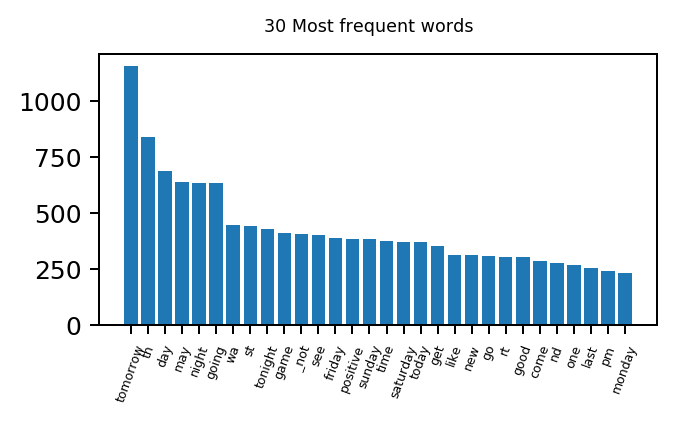

In [23]:
import collections
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import numpy as np

word_list = [word for line in final_tweets for word in line.split()]
counter = collections.Counter(word_list)

labels = [item[0] for item in counter.most_common(30)]
number = [item[1] for item in counter.most_common(30)]
nbars = len(counter.most_common(30))

plt.figure(figsize=(4,2), dpi=180)
plt.xticks(rotation=70, fontsize=5)
plt.bar(np.arange(nbars), number, tick_label=labels)
plt.suptitle("30 Most frequent words",fontsize=7)
plt.show()

In [24]:
counter["tomorrow"]

1153

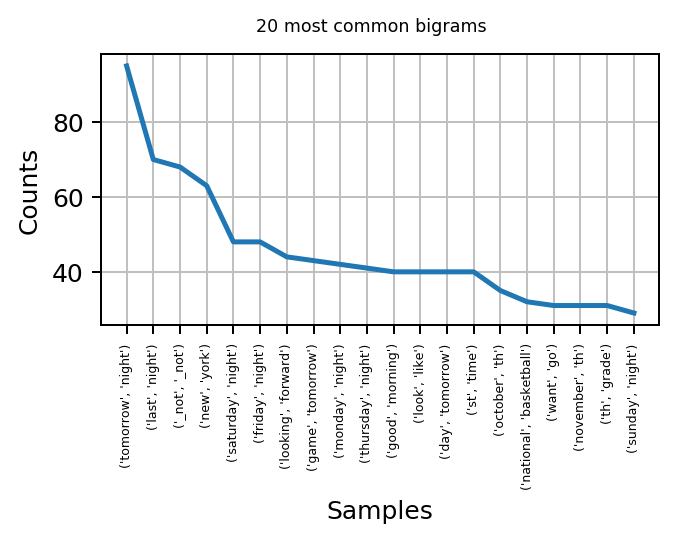

In [25]:
def find_bigrams(input_list):
    bigram_list = []
    for i in range(len(input_list)-1):
        bigram_list.append((input_list[i], input_list[i+1]))
    return bigram_list

bigram_list = find_bigrams(word_list)
freq_bi = nltk.FreqDist(bigram_list)


freq_bi.most_common(30)
plt.figure(figsize=(4,2), dpi=180)
plt.xticks(fontsize=5)
plt.suptitle("20 most common bigrams",fontsize=7)
freq_bi.plot(20)

***
## <font color='red'>Lexicon Classification</font>
***

#### Using MPQA Lexicon

These are the very first and last entries of the file 'mpqa.txt'
- abandoned priorpolarity=negative
- abandonment priorpolarity=negative
- abandon priorpolarity=negative
- abase priorpolarity=negative
- abasement priorpolarity=negative
- ...
- zealot priorpolarity=negative
- zealous priorpolarity=negative
- zealously priorpolarity=negative
- zenith priorpolarity=positive
- zest priorpolarity=positive

In [27]:
from nltk.tokenize import TweetTokenizer

TT = TweetTokenizer()

def MPQAdictionary(filename):
    """
    reads mpqa file which contains the polarity of some of the english words. e.g. 'love': 'positive'
    """
    MPQA_scores = {'priorpolarity=positive\n': 'positive','priorpolarity=negative\n': 'negative',
                  'priorpolarity=neutral\n': 'neutral', 'priorpolarity=both\n': 'neutral'}
    MPQA_score_list = {}
    fi = open(filename,"r")
    line = fi.readline()
    while line: 
        # line = line.replace("\xc2\xa0"," ")
        li = line.split(" ")
        l2 = li[:-1] # the word as a list
        # l2.append(li[len(li) - 1])
        sentiment=li[1] #the word's polarity
        score=MPQA_scores[sentiment]
        l2.append(score)
        for i in range(0,len(l2)-1):
            MPQA_score_list[l2[i]]=l2[-1]
            # negation
            if l2[-1] == 'positive':
                MPQA_score_list[l2[i]+'_not']='positive' 
            else:
                MPQA_score_list[l2[i]+'_not']='negative' 
        line=fi.readline()
    #print(MPQA_score_list)
    return MPQA_score_list

dictionary = MPQAdictionary('./resources/mpqa/mpqa.txt')
print ("Number of MPQA words: %d" % len(dictionary.keys()))


def subsMPQA(tweet,d):
    l = TT.tokenize(tweet)
    #print(l)
    tweet = [d[i] if i in d.keys() else i for i in l]
    return tweet

raw_tweets_MPQA = [subsMPQA(tweet,dictionary) for tweet in final_tweets]
#print (raw_tweets_MPQA)

print (subsMPQA(final_tweets[7], dictionary))
# watched sridevis comeback remember sun morning nta positive
subsMPQA("surprise happy abandoned", dictionary)

Number of MPQA words: 13772
['watched', 'sridevis', 'positive', 'remember', 'sun', 'morning', 'nta', 'positive']


['neutral', 'positive', 'negative']

#### Using Bing Liu Lexicon
These are the very first and last entries of the file 'positive-words.txt':
- a+
- abound
- abounds
- abundance
- abundant
- ...
- youthful
- zeal
- zenith
- zest
- zippy

These are the very first and last entries of the file 'negative-words.txt':
- 2-faced
- 2-faces
- abnormal
- abolish
- abominable
- ...
- zaps
- zealot
- zealous
- zealously
- zombie

In [30]:
import os
from copy import copy

TT = TweetTokenizer()
mmer = WordNetLemmatizer()

# lemmatize the tweets
def _lemma(tweet):
    return ' '.join([mmer.lemmatize(word) for word in tweet])

stemmed_tweets_MPQA = [_lemma(tweet) for tweet in raw_tweets_MPQA]
#print(stemmed_tweets_MPQA)

ENGLISH_OPINION_LEXICON_LOCATION = os.path.join('resources/opinion-lexicon-English')
POS_WORDS_FILE = os.path.join(ENGLISH_OPINION_LEXICON_LOCATION, 'positive-words.txt')
NEG_WORDS_FILE = os.path.join(ENGLISH_OPINION_LEXICON_LOCATION, 'negative-words.txt')

pos_words = []
neg_words = []

for pos_word in open(POS_WORDS_FILE, 'r').readlines()[35:]:
    pos_words.append(pos_word.rstrip())

for neg_word in open(NEG_WORDS_FILE, 'r').readlines()[35:]: #HERE
    neg_words.append(neg_word.rstrip())

#negation
expanded_pos = copy(pos_words)
expanded_pos.extend([word+"_not" for word in neg_words])
expanded_neg = copy(neg_words)
expanded_neg.extend([word+"_not" for word in pos_words])
print ("Number of positive words %d" % len(expanded_pos))
print ("Number of negative words %d" % len(expanded_neg))
#print(pos_words)

def subsBINGP(tweet, pos_words):
    l = TT.tokenize(tweet)
    tweet = ['positive' if i in pos_words else i for i in l]
    return tweet

def subsBINGN(tweet, neg_words):
    l = TT.tokenize(tweet)
    tweet = ['negative' if i in neg_words else i for i in l]
    return tweet

raw_tweets_bing = [subsBINGP(tweet, expanded_pos) for tweet in stemmed_tweets_MPQA]
raw_tweets_bing = [subsBINGN(tweet, expanded_neg) for tweet in stemmed_tweets_MPQA]

stemmed_final = [_lemma(tweet) for tweet in raw_tweets_bing]
#print(stemmed_final)

#print(raw_tweets_bing)
subsBINGP("enjoy firas extraordinarily", pos_words)

Number of positive words 6789
Number of negative words 6789


['positive', 'firas', 'positive']

#### [Afinn](https://pypi.python.org/pypi/afinn)

These are the very first and last entries of 'afinn.txt':
- abandon	-2
- abandoned	-2
- abandons	-2
- abducted	-2
- abduction	-2
- ...
- yucky	-2
- yummy	3
- zealot	-2
- zealots	-2
- zealous	2

In [33]:
def loadAfinn(filename):
    f=open(filename,'r')
    afinn={}
    line=f.readline()
    while line:
        if " " in line:   #exclude entries like 'cool stuff		3'
            pass
        else:
            l=line[:-1].split('\t') #line[:-1] removes the '\n' character
            afinn[l[0]]=float(l[1])/5.2    # normalization -------> 
            afinn[l[0]+"_not"] = -float(l[1])/5.2  # negation
        line=f.readline()

    return afinn

afinn = loadAfinn('./resources/afinn.txt')
# print (afinn)
print ("Number of Afinn entries %d" % len(afinn.keys()))

def afinnPolarity(tweet,afinn):
    p=0.0
    for w in tweet:
        if w in afinn.keys():
            p+=afinn[w]
    return p

Number of Afinn entries 4922


#### SemEval2015 English lexicon 

These are the very first and last entries of 'SemEval2015-English-Twitter-Lexicon.txt':
- 0.984	loves
- 0.984	#inspirational
- 0.969	amazing
- 0.969	#peaceful
- 0.953	#greatness
- ...
- -0.969	abuse
- -0.969	#failure
- -0.982	kill
- -0.984	bitches
- -0.984	#disappointment

In [36]:
def loadSemEval(filename):
    f=open(filename,'r')
    lexicon={}
    line=f.readline()
    while line:
        l=line[:-1].split('\t')
        lexicon[l[1]]=float(l[0]) # normalisation  -----> HERE /4
        lexicon[l[1]+'_not']=-float(l[0]) # negation
        line=f.readline()

    return lexicon

EnglishLexicon = loadSemEval('./resources/SemEval2015-English-Twitter-Lexicon.txt')
# print (EnglishLexicon)
print ("Number of EnglishLexicon entries %d" % len(EnglishLexicon.keys()))


def SemEvalLexiconPolarity(tweet,EnglishLexicon):
    p=0.0
    for w in tweet:
        if w in EnglishLexicon.keys():
            p+=EnglishLexicon[w]
    return p

Number of EnglishLexicon entries 3032


#### SentiWordNet

Here is the very first five lines of the csv file 'sentiWordnetBig.csv':

|POS|ID|PosSCore|NegScore|SynsetTerms|
|-|-------|-----|-----|-------------------|
|a|1740|0.125|0|able#1|
|a|2098|0|0.75|unable#1|
|a|2312|0|0|dorsal#2 abaxial#1|
|a|2527|0|0|ventral#2 adaxial#1|
|a|2730|0|0|acroscopic#1|

In [37]:
def loadSentiWordnet(filename): 
    output={}
    print ("Opening the SentiWordnet file ...")
    fi=open(filename,"r")
    line=fi.readline() # ignore the header
    line=fi.readline()
    print ("Loading...")

    while line:
        l=line.split('\t')
        try:
            sentence=l[4]
            new = [word for word in sentence.split() if (word[-2] == "#" and word[-1].isdigit())]
            pos=abs(float(l[2]))
            neg=abs(float(l[3]))
            neu=float(pos-neg)
        except:
            line=fi.readline()
            continue

        for w in new:
            output[(w[:-2])]=neu
            output[(w[:-2])+'_not'] = -neu   #negation
        line=fi.readline()
        
    fi.close()
    return output


sentiWordnet = loadSentiWordnet('./resources/sentiWordnetBig.csv')
# print (sentiWordnet)
print ("Number of sentiWordnet entries %d" % len(sentiWordnet.keys()))



def WordnetPolarity(tweet,sentiWordnet):
    p=0.0
    for w in tweet:
        if w in sentiWordnet.keys():
            p+=sentiWordnet[w]
    return p

Opening the SentiWordnet file ...
Loading...
Number of sentiWordnet entries 294612


### Polarity calculation

In [38]:
# Combine the score of 5 lexicons:
# Afinn / MPQA / Bing Liu / WordNet / SemEval-Lexicon

final_score_tweets = []

for tw in raw_tweets_bing:
    AfinnScore = afinnPolarity(tw,afinn)
    WordnetScore = WordnetPolarity(tw,sentiWordnet)
    SemEvalLexicon = SemEvalLexiconPolarity(tw,EnglishLexicon)
    
    score_Bing_MPQA = 0
    for i in tw:
        if (i == 'positive'):
            score_Bing_MPQA +=  0.844
        if (i == 'negative'):
            score_Bing_MPQA -= 0.844
        
    final_score_tweets.append(score_Bing_MPQA + AfinnScore + WordnetScore + SemEvalLexicon)

#final_score_tweets (my score list)
df['score_tweets_lexicon'] = final_score_tweets
df[['score_tweets_lexicon', 'final_tweets' ,2]].head(25)

,score_tweets_lexicon,final_tweets,2
0,1.931615,gas house hit going chapel hill sat positive,positive
3,4.317231,iranian general say israels iron dome deal_not...,negative
6,1.931615,davlar th main rival team poland hopefully mak...,positive
7,-0.407000,talking acts sats deciding want go college app...,negative
9,-2.697615,may superbowl dallas dallas winning_not superb...,negative
10,-0.797000,message bringing monster load candy tomorrow h...,neutral
11,-0.516000,apple software retail overhaul san francisco a...,neutral
12,4.958231,watched sridevis comeback remember sun morning...,positive
14,2.869615,#livewire nadal confirmed mexican open februar...,neutral
15,4.525231,didnt want pop yep chapel hill next wednesday ...,positive


##### Comparing the scores with the real results, we can conclude that the use of lexicon does not give very good results ... We must add scores for bi-grams.
##### You must then combine the lexicon / machine learning!

***

***
## <font color='red'>Train the model</font>
***
#### Create a feature vector
* See [Bag of Words](https://en.wikipedia.org/wiki/Bag-of-words_model) for more details

In [39]:
# Use vectorizer count
from sklearn.feature_extraction.text import CountVectorizer

# Use bigram by creating the vector
vectorizer = CountVectorizer(analyzer='word', preprocessor=None, stop_words=None, 
                             tokenizer=None,  ngram_range=(1,2))

#features = vectorizer.fit_transform(final_tweets) # (7205, 66156)

features = vectorizer.fit_transform(final_tweets)
features.shape

(7205, 67463)

#### Put labels to train

In [40]:
labels = df[2]
mapper = {'positive': 1, 'negative': -1, 'neutral': 0}

labels = labels.map(mapper)
labels.shape

(7205,)

### Features selection

##### To install xgboost on mac : [Tuto](https://isaacchanghau.github.io/2017/06/20/Install-XGBoost-on-Mac-OS-X/) 
##### To install xgboost on ubuntu : [Tuto](https://gist.github.com/pratos/de49be8ec53378145ea0df0a04ea7b25) 
![title](./resources/img/Filter.png)

In [41]:
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.model_selection import train_test_split
from numpy import sort

# fit model on all training data
model = XGBClassifier()
model.fit(features, labels)

# thresholds = sort(model.feature_importances_)
# print (len(thresholds))
# thresholds

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [23]:
## TAKES 2h for the execution

#for thresh in thresholds:
    # select features using threshold
#    selection = SelectFromModel(model, threshold=thresh, prefit=True)    
#    select_X_train = selection.transform(features)

In [24]:
#select_X_train.shape

#### Import SVM

http://scikit-learn.org/stable/modules/svm.html

For a mathematical overview,
https://docs.opencv.org/2.4/doc/tutorials/ml/introduction_to_svm/introduction_to_svm.html

#### Get the optimal regulation parameter using handout method

Max value of 0.999 occured at C=1.300


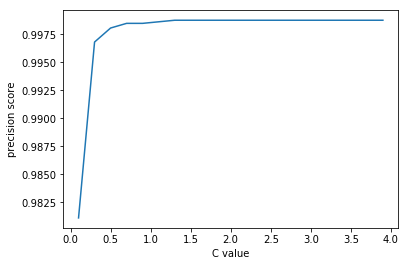

In [64]:
# DON'T RUN THIS
# Takes around 20 minutes
from sklearn import metrics
from sklearn.svm import SVC
import numpy as np

KERNEL = 'linear'
C_start = 0.1
C_end = 4.0
C_inc = 0.20

C_values, precision_scores = [], []

C_val = C_start
best_precision_score = 0
while (C_val < C_end):
    C_values.append(C_val)
    svc_model_loop = SVC(C=C_val, kernel=KERNEL, random_state=42)
    svc_model_loop.fit(features, labels.ravel())
    svc_predict_loop_test = svc_model_loop.predict(features)
    
    precision_score = metrics.precision_score(labels, svc_predict_loop_test, average='micro')
    precision_scores.append(precision_score)
    if (precision_score > best_precision_score):
        best_precision_score = precision_score
        best_lr_predict_test = svc_predict_loop_test
        
    C_val = C_val + C_inc

best_score_C_val = C_values[precision_scores.index(best_precision_score)]
print("Max value of {0:.3f} occured at C={1:.3f}".format(best_precision_score, best_score_C_val))

%matplotlib inline 
plt.plot(C_values, precision_scores, "-")
plt.xlabel("C value")
plt.ylabel("precision score")

In [42]:
from sklearn.svm import SVC

best_score_C_val = 1.300
KERNEL = 'linear'
classifier = SVC(kernel=KERNEL, C=best_score_C_val)
classifier.fit(features, labels)

SVC(C=1.3, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### Prediction on training data

In [43]:
from sklearn import metrics

nb_predict_train = classifier.predict(features)

#check accuracy
print("Accuracy: {:0.4f}".format(metrics.accuracy_score(labels, nb_predict_train)))

Accuracy: 0.9988


In [44]:
#print confusion matrix
print("{}".format(metrics.confusion_matrix(labels, nb_predict_train, 
                                           labels=[1,-1, 0])))

print("{}".format(metrics.classification_report(labels, nb_predict_train, 
                                                labels=[1, -1, 0])))

[[2686    1    5]
 [   0 1022    2]
 [   1    0 3488]]
             precision    recall  f1-score   support

          1       1.00      1.00      1.00      2692
         -1       1.00      1.00      1.00      1024
          0       1.00      1.00      1.00      3489

avg / total       1.00      1.00      1.00      7205



### Predict using the model
***

#### Import test data

In [45]:
t_df = pd.read_csv('./data/test/actual/test_B_labeled.tsv', sep='\t', header=None)
t_df.shape

(8902, 4)

In [46]:
t_df = t_df[t_df[3] != 'Not Available']
#t_df = t_df[t_df[2] != 'neutral']
t_df.shape

(7584, 4)

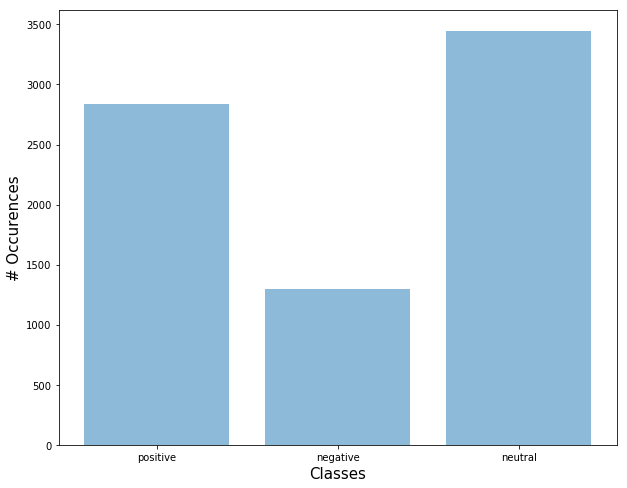

In [47]:
# The bar chart for the test data set

y = [len(t_df[t_df[2] == i]) for i in ['positive', 'negative', 'neutral']]
x = ['positive', 'negative', 'neutral']
x_pos = range(len(x))

plt.figure(figsize=(10,8))
plt.bar(x_pos, y, alpha=0.5)
plt.xticks(x_pos, x)
plt.ylabel('# Occurences').set_size(15)
plt.xlabel('Classes').set_size(15)

#### Pre-process tweets from the test dataset

In [57]:
raw_tweets_test = t_df[3]
raw_tweets_test = [replaceSlangs(tweet, slangs) for tweet in raw_tweets_test]
raw_tweets_test = [replace_apostrophe(tweet, apos) for tweet in raw_tweets_test]
raw_tweets_test = [replaceSlangs(tweet, parasite_words) for tweet in raw_tweets_test]
raw_tweets_test = [subsEmoticon(tweet, dict) for tweet in raw_tweets_test]
raw_tweets_test = [handle_negation(tweet) for tweet in raw_tweets_test] #negation
stemmed_tweets_test = [_lemma(tweet) for tweet in raw_tweets_test]
preprocessed_tweets_test = [preprocess(tweet) for tweet in stemmed_tweets_test]
final_tweets_test = [rem_stop(tweet) for tweet in preprocessed_tweets_test]
# t_df[3] = final_tweets_test



## add part for lexicons
# raw_tweets_MPQA_test = [subsMPQA(tweet,dictionary) for tweet in final_tweets_test]
# stemmed_tweets_MPQA_test = [_lemma(tweet) for tweet in raw_tweets_MPQA_test]
# raw_tweets_bing_test = [subsBINGP(tweet, pos_words) for tweet in stemmed_tweets_MPQA_test]
# raw_tweets_bing_test = [subsBINGN(tweet, neg_words) for tweet in stemmed_tweets_MPQA_test]
# stemmed_final = [_lemma(tweet) for tweet in raw_tweets_bing_test]
# t_df[3] = stemmed_final

In [50]:
t_df.head()

,0,1,2,3
2,282031301962395648,T14111200,neutral,dec 21st 2012 will be know not as the end of t...
3,11975,SM112166,negative,Yar he quite clever but aft many guesses lor. ...
4,136592,LJ112295,negative,Yeah we have Thin Lizzy here I HATE the inform...
5,253421252956545024,T13114433,neutral,"MT @LccSy #Syria, Deir Ezzor: Ali Bashar al-th..."
6,220880422320603137,T14114138,negative,"@MacMiller hate my life, because i can't see y..."


#### Create the features vector

In [58]:
# test_features = vectorizer.transform(stemmed_final)
test_features = vectorizer.transform(final_tweets_test)
test_features.shape

(7584, 67463)

#### Get labels from a set of test data

In [59]:
actual_labels = t_df[2]
actual_labels = actual_labels.map(mapper)
actual_labels.shape

(7584,)

#### Predict labels using the template

In [60]:
predicted_labels = classifier.predict(test_features)

### Evaluate the Model
***

#### Evaluate the accuracy

In [61]:
print('Accuracy: {:0.2f}%'.format(metrics.accuracy_score(actual_labels, predicted_labels) * 100))

Accuracy: 65.19%


#### Accuracy of cross-validation 10 times on test data

In [46]:
from sklearn import model_selection
scores = model_selection.cross_val_score(classifier, test_features, actual_labels, cv=10, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.64 (+/- 0.03)


In [39]:
#from sklearn import model_selection
        
#scores = model_selection.cross_val_score(classifier, actual_labels, predicted_labels, cv=10, scoring='accuracy')
#print("Accuracy cross val X10: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [62]:
# draw the classification report
print('{}'.format(metrics.classification_report(actual_labels, predicted_labels)))

             precision    recall  f1-score   support

         -1       0.65      0.30      0.41      1296
          0       0.61      0.84      0.71      3448
          1       0.73      0.58      0.65      2840

avg / total       0.66      0.65      0.64      7584



See [Confusion Matrix](https://fr.wikipedia.org/wiki/Matrice_de_confusion) for more details


In [63]:
# Confusion Matrix
print('{}\n'.format(metrics.confusion_matrix(actual_labels, predicted_labels, labels=[1,-1,0])))
print("\x1b[31m\" micro f1 score \"\x1b[0m")
print('{}\n'.format(metrics.f1_score(actual_labels, predicted_labels, average='macro')))
print("\x1b[31m\" macro f1 score \"\x1b[0m")
print('{}\n'.format(metrics.f1_score(actual_labels, predicted_labels, average='micro')))

[[1660   98 1082]
 [ 156  395  745]
 [ 443  116 2889]]

" micro f1 score "
0.5911825088054546

" macro f1 score "
0.6518987341772152



### Comparison with the 5 best teams of subtask B

We compare our average f-score with the other teams in the workshop. The results are taken from the attached document:
[Final report SemEval 2014 Subtask 9](http://www.aclweb.org/anthology/S14-2009)

|Team|Accuracy (Macro Averaged)| Accuracy (Micro Averaged)|
|----|-------------------------|--------------------------|
|TeamX|65.63%|69.99%|
|coooolll|63.23%|70.51%|
|RTRGO|63.08%|70.15%|
|NRC-Canada|67.62%|71.37%|
|TUGAS|63.89%|68.84%|
|**_ME_**|_57.48%_|_64.86%_|
| | |***classement : 23 / 50***|
 